# Cluster-Based Predictive Modeling (NBA Fantasy Points)

# Setup

### Imports

In [52]:
import os
import optuna
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, root_mean_squared_error
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor


from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from optuna.integration import OptunaSearchCV
from optuna.distributions import FloatDistribution, IntDistribution, CategoricalDistribution

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Load Data into DataFrame

In [53]:
data_dir = '/teamspace/uploads/'
df = pd.read_parquet(f'{data_dir}player_stats_with_clusters_2022_2024_2.parquet')
print(f'Shape: {df.shape} \n{df.columns}')

Shape: (55968, 55) 
Index(['Date', 'Name', 'Team', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
       'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
       'PF', 'PTS', 'GmSc', '+-', 'TeamAbbr', 'GameLink', 'Opponent', 'Home',
       'GameType', 'id', 'fpts_fanduel', 'Season', 'FG_2game_avg',
       'FGA_2game_avg', 'FG%_2game_avg', '3P_2game_avg', '3PA_2game_avg',
       '3P%_2game_avg', 'FT_2game_avg', 'FTA_2game_avg', 'FT%_2game_avg',
       'ORB_2game_avg', 'DRB_2game_avg', 'TRB_2game_avg', 'AST_2game_avg',
       'STL_2game_avg', 'BLK_2game_avg', 'TOV_2game_avg', 'PF_2game_avg',
       'PTS_2game_avg', 'GmSc_2game_avg', '+-_2game_avg',
       'fpts_fanduel_2game_avg', 'PTS_per_FGA_2game_avg', 'kmeans_cluster'],
      dtype='object')


In [54]:
df.head()

Date               Name                   Team         MP  FG  \
4557  2022-10-18        noah vonleh         Boston Celtics  20.166667   1   
14351 2022-10-18  de'anthony melton     Philadelphia 76ers  20.550000   2   
3461  2022-10-18      blake griffin         Boston Celtics   8.283333   0   
9848  2022-10-18   danuel house jr.     Philadelphia 76ers  16.200000   0   
12649 2022-10-18   donte divincenzo  Golden State Warriors  21.616667   3   

       FGA  FG%  3P  3PA  3P%  ...  STL_2game_avg  BLK_2game_avg  \
4557     2  0.5   0    0  0.0  ...            0.0            0.0   
14351    4  0.5   1    2  0.5  ...            0.5            0.0   
3461     2  0.0   0    1  0.0  ...            1.5            0.0   
9848     2  0.0   0    1  0.0  ...            1.0            0.0   
12649    6  0.5   1    2  0.5  ...            1.0            0.0   

       TOV_2game_avg  PF_2game_avg  PTS_2game_avg  GmSc_2game_avg  \
4557             1.0           2.5            1.0           -1.25   
14351            0.0           0.0            1.5            1.80   
3461             2.0           4.5            6.0            5.95   
9848             1.0           1.0            1.5            1.60   
12649            0.5           1.0           11.0            8.40   

       +-_2game_avg  fpts_fanduel_2game_avg  PTS_per_FGA_2game_avg  \
4557           -2.0                    2.40               0.666667   
14351          -9.0                    6.45               0.600000   
3461           -9.5                   21.40               1.000000   
9848           -3.0                   12.95               0.272727   
12649          -3.5                   17.40               1.375000   

       kmeans_cluster  
4557                0  
14351               0  
3461                1  
9848                0  
12649               0  

[5 rows x 55 columns]

In [55]:
df[df['fpts_fanduel'] == 0].shape[0]

3253

In [56]:
df = df[df['fpts_fanduel'] > 0]

### Correlation Matrix

In [57]:
df.isnull().sum().sum()

0

In [58]:
numeric_columns = [
  'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
  'FT', 'FTA', 'FT%', 'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV',
  'PF', 'PTS', 'GmSc', '+-', 'fpts_fanduel', 'Home','FG_2game_avg', 'FGA_2game_avg', 
  'FG%_2game_avg', '3P_2game_avg','3PA_2game_avg', '3P%_2game_avg', 'FT_2game_avg', 
  'FTA_2game_avg','FT%_2game_avg', 'ORB_2game_avg', 'DRB_2game_avg', 'TRB_2game_avg', 
  'AST_2game_avg', 'STL_2game_avg', 'BLK_2game_avg', 'TOV_2game_avg', 
  'PF_2game_avg', 'PTS_2game_avg', 'GmSc_2game_avg', '+-_2game_avg',
  'fpts_fanduel_2game_avg', 'PTS_per_FGA_2game_avg', 'kmeans_cluster'
]

filtered_df = df[numeric_columns]
correlation_matrix = filtered_df.corr()

# Convert the correlation matrix to long format
correlation_matrix_long = correlation_matrix.reset_index().melt(id_vars='index')
correlation_matrix_long.columns = ['Feature1', 'Feature2', 'Correlation']

# Create an interactive heatmap using Plotly
fig = px.imshow(correlation_matrix,
                labels=dict(x="Features", y="Features", color="Correlation"),
                x=correlation_matrix.columns,
                y=correlation_matrix.columns,
                color_continuous_scale='RdBu_r',
                zmin=-1, zmax=1,
                aspect="auto")

# Customize the layout for better visibility
fig.update_layout(
    title="Correlation Heatmap of Selected Features with Target Variable",
    xaxis_title="Features",
    yaxis_title="Features",
    width=1400,
    height=1200
)

# Add hover information with the correlation value and feature names
fig.update_traces(hovertemplate='Correlation: %{z}<br>Feature 1: %{x}<br>Feature 2: %{y}')

# Show the interactive plot
fig.show()

## Data Preparation

In [59]:
selected_features = [
    'MP', 'FG_2game_avg', 'FGA_2game_avg', 'FG%_2game_avg', '3P_2game_avg', 
    '3PA_2game_avg', '3P%_2game_avg', 'FT_2game_avg', 'FTA_2game_avg', 
    'FT%_2game_avg', 'ORB_2game_avg', 'DRB_2game_avg', 'TRB_2game_avg', 
    'AST_2game_avg', 'STL_2game_avg', 'BLK_2game_avg', 'TOV_2game_avg', 
    'PF_2game_avg', 'PTS_2game_avg', 'GmSc_2game_avg', 'PTS_per_FGA_2game_avg'
]

X = df[selected_features]

In [60]:
upper = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > .85)]
to_drop_filtered = [column for column in to_drop if column in X.columns]
X = X.drop(columns=to_drop_filtered)


X['Intercept'] = 1
vif = pd.DataFrame()
vif['Feature'] = X.columns
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif = vif.drop(index=vif[vif['Feature'] == 'Intercept'].index)
print(vif)

                  Feature       VIF
0                      MP  1.836173
1            FG_2game_avg  4.521933
2           FG%_2game_avg  3.331183
3            3P_2game_avg  3.075635
4           3P%_2game_avg  2.210061
5            FT_2game_avg  3.022885
6           FT%_2game_avg  2.271951
7           ORB_2game_avg  1.494128
8           DRB_2game_avg  1.924554
9           AST_2game_avg  1.834351
10          STL_2game_avg  1.203868
11          BLK_2game_avg  1.234087
12          TOV_2game_avg  1.800986
13           PF_2game_avg  1.304469
14  PTS_per_FGA_2game_avg  2.924607


## Select Features

In [61]:
features = [
  'MP', 'FG_2game_avg', 'FG%_2game_avg', '3P_2game_avg', '3P%_2game_avg', 
  'FT_2game_avg', 'FT%_2game_avg', 'ORB_2game_avg', 'DRB_2game_avg', 
  'AST_2game_avg', 'STL_2game_avg', 'BLK_2game_avg', 'TOV_2game_avg', 
  'PF_2game_avg', 'PTS_per_FGA_2game_avg', 'Home','kmeans_cluster'
]

X = df[features]
y = df['fpts_fanduel']
print(f'X: {X.shape}')
print(f'y: {y.shape}')
X.describe()

X: (52426, 17)
y: (52426,)


MP  FG_2game_avg  FG%_2game_avg  3P_2game_avg  3P%_2game_avg  \
count  52426.000000  52426.000000   52426.000000  52426.000000   52426.000000   
mean      23.666010      4.087409       0.443805      1.228551       0.267260   
std       10.556567      2.988606       0.187420      1.261876       0.221694   
min        0.066667      0.000000       0.000000      0.000000       0.000000   
25%       15.783333      2.000000       0.333500      0.000000       0.000000   
50%       24.483333      3.500000       0.457000      1.000000       0.250000   
75%       32.283333      6.000000       0.550000      2.000000       0.433500   
max       55.100000     20.000000       1.000000     10.000000       1.000000   

       FT_2game_avg  FT%_2game_avg  ORB_2game_avg  DRB_2game_avg  \
count  52426.000000   52426.000000   52426.000000   52426.000000   
mean       1.727368       0.434626       1.008984       3.191079   
std        2.067519       0.345402       1.122644       2.356968   
min        0.000000       0.000000       0.000000       0.000000   
25%        0.000000       0.000000       0.000000       1.500000   
50%        1.000000       0.500000       0.500000       2.500000   
75%        2.500000       0.750000       1.500000       4.500000   
max       19.000000       1.000000      10.500000      16.500000   

       AST_2game_avg  STL_2game_avg  BLK_2game_avg  TOV_2game_avg  \
count   52426.000000   52426.000000   52426.000000   52426.000000   
mean        2.519857       0.713882       0.471474       1.271049   
std         2.387896       0.720703       0.669345       1.152265   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       0.000000       0.000000       0.500000   
50%         2.000000       0.500000       0.500000       1.000000   
75%         3.500000       1.000000       0.500000       2.000000   
max        21.500000       6.000000       7.500000       8.500000   

       PF_2game_avg  PTS_per_FGA_2game_avg          Home  kmeans_cluster  
count  52426.000000           52426.000000  52426.000000    52426.000000  
mean       1.865420               1.263587      0.499714        0.675047  
std        1.155458               0.506691      0.500005        0.715842  
min        0.000000               0.000000      0.000000        0.000000  
25%        1.000000               1.000000      0.000000        0.000000  
50%        2.000000               1.266667      0.000000        1.000000  
75%        2.500000               1.521739      1.000000        1.000000  
max        6.000000              10.000000      1.000000        2.000000

In [62]:
y.describe()

count    52426.000000
mean        22.516917
std         14.831503
min          0.200000
25%         10.900000
50%         20.300000
75%         31.900000
max        105.200000
Name: fpts_fanduel, dtype: float64

Models to try:
- Linear Regression
- SGDRegressor
- KNeighborsRegressor
- Support Vector Regression
- XGBoost
- LightGBM
- CatBoost

## Data Split

### Data Splits by Cluster

In [63]:
clusters = X['kmeans_cluster'].unique()

data_splits = {}

for cluster in clusters:
  X_cluster = X[X['kmeans_cluster'] == cluster]
  y_cluster = y[X['kmeans_cluster'] == cluster]

  X_cluster = X_cluster.drop(columns=['kmeans_cluster'])

  X_train, X_temp, y_train, y_temp = train_test_split(X_cluster, y_cluster, test_size=0.2, random_state=42, shuffle=False)
  X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.1111, random_state=42, shuffle=False)


  data_splits[cluster] = {
    'X_train': X_train,
    'X_val': X_val,
    'X_test': X_test,
    'y_train': y_train,
    'y_val': y_val,
    'y_test': y_test
  }


In [64]:
# Iterating through the dictionary and printing the shapes
for cluster_label, splits in data_splits.items():
    print(f"Cluster {cluster_label}:")
    print(f"  X_train shape: {splits['X_train'].shape}")
    print(f"  X_val shape: {splits['X_val'].shape}")
    print(f"  X_test shape: {splits['X_test'].shape}")
    print(f"  y_train shape: {splits['y_train'].shape}")
    print(f"  y_val shape: {splits['y_val'].shape}")
    print(f"  y_test shape: {splits['y_test'].shape}")
    print(f"Total: {sum([splits['X_train'].shape[0], splits['X_val'].shape[0], splits['X_test'].shape[0]])}")
    print("-" * 50)

Cluster 0:
  X_train shape: (19774, 16)
  X_val shape: (4394, 16)
  X_test shape: (550, 16)
  y_train shape: (19774,)
  y_val shape: (4394,)
  y_test shape: (550,)
Total: 24718
--------------------------------------------------
Cluster 1:
  X_train shape: (16020, 16)
  X_val shape: (3560, 16)
  X_test shape: (446, 16)
  y_train shape: (16020,)
  y_val shape: (3560,)
  y_test shape: (446,)
Total: 20026
--------------------------------------------------
Cluster 2:
  X_train shape: (6145, 16)
  X_val shape: (1366, 16)
  X_test shape: (171, 16)
  y_train shape: (6145,)
  y_val shape: (1366,)
  y_test shape: (171,)
Total: 7682
--------------------------------------------------


### Whole Dataset Split

In [65]:
X = X.drop(columns=['kmeans_cluster'])

In [66]:
print(X.shape)
X.head()

(52426, 16)


MP  FG_2game_avg  FG%_2game_avg  3P_2game_avg  3P%_2game_avg  \
4557   20.166667           0.5         0.2500           0.0         0.0000   
14351  20.550000           0.5         0.1665           0.5         0.1665   
3461    8.283333           2.5         0.4715           0.0         0.0000   
9848   16.200000           0.5         0.0835           0.5         0.1000   
12649  21.616667           3.5         0.4165           3.0         0.4855   

       FT_2game_avg  FT%_2game_avg  ORB_2game_avg  DRB_2game_avg  \
4557            0.0            0.0            0.0            2.0   
14351           0.0            0.0            0.0            1.0   
3461            1.0            0.5            1.5            3.0   
9848            0.0            0.0            0.0            1.0   
12649           1.0            0.5            0.5            1.5   

       AST_2game_avg  STL_2game_avg  BLK_2game_avg  TOV_2game_avg  \
4557             0.0            0.0            0.0            1.0   
14351            1.5            0.5            0.0            0.0   
3461             5.0            1.5            0.0            2.0   
9848             5.5            1.0            0.0            1.0   
12649            1.0            1.0            0.0            0.5   

       PF_2game_avg  PTS_per_FGA_2game_avg  Home  
4557            2.5               0.666667     1  
14351           0.0               0.600000     0  
3461            4.5               1.000000     1  
9848            1.0               0.272727     0  
12649           1.0               1.375000     1

In [67]:
print(y.shape)
y.head()

(52426,)


4557     10.4
14351     8.0
3461      8.5
9848      8.7
12649    12.4
Name: fpts_fanduel, dtype: float64

In [68]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle=False)

print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"Total: {sum([X_train.shape[0], X_val.shape[0], X_test.shape[0]])}")
print("-" * 50)

X_train shape: (41940, 16)
X_val shape: (5243, 16)
X_test shape: (5243, 16)
y_train shape: (41940,)
y_val shape: (5243,)
y_test shape: (5243,)
Total: 52426
--------------------------------------------------


# Model Parameters

In [432]:
# Model Setup
models = {
    'LinearRegression': (LinearRegression(), {
      'fit_intercept': [False, True],
      }),

    'SGDRegressor': (SGDRegressor(), {
      'alpha': [0.0001, 0.001, 0.01, .1], 
      'max_iter': [2000, 3000, 5000], 
      'loss': ['squared_error', 'huber'],
      'penalty': ['l1', 'l2'],
      'fit_intercept': [False, True]
      }),

    'LinearSVR': (LinearSVR(), {
      'C': [0.01, 0.1, 1.0, 10.0], 
      'max_iter': [2000, 3000, 5000],
      'fit_intercept': [False, True]
      }),

    'XGBoost': (xgb.XGBRegressor(), {
      'n_estimators': [300, 500, 1000], 
      'learning_rate': [0.01, 0.1, 0.2, .3],
      'max_depth': [6, 8, 10],
      'min_child_weight': [5, 10, 100, 300],
      'subsample': [0.5],
      'seed': 42
      }),

    'LightGBM': (lgb.LGBMRegressor(), {
      'n_estimators': [50, 100, 200], 
      'learning_rate': [0.01, 0.1, 0.2]
      }),

    'CatBoost': (CatBoostRegressor(silent=True), {
      'iterations': [100, 200, 300], 
      'learning_rate': [0.01, 0.1, 0.2]
      })
}

# XGBoost

## Setup

In [69]:
xgb = xgb.XGBRegressor()

xgb_params = {
  'max_depth': IntDistribution(3, 3),  
  'min_child_weight': IntDistribution(6, 8), 
  'learning_rate': FloatDistribution(0.135, 0.15),
  'subsample': FloatDistribution(0.86, 0.89), 
  'colsample_bytree': FloatDistribution(0.75, 0.86), 
  'colsample_bylevel': FloatDistribution(0.82, 0.87),
  'colsample_bynode': FloatDistribution(0.79, 0.88), 
  'gamma': FloatDistribution(2.0, 4.0),  
  'lambda': FloatDistribution(4.5, 7.0),
  'alpha': FloatDistribution(2.0, 5.5),
  'max_delta_step': IntDistribution(6, 9), 
  'booster': CategoricalDistribution(['gbtree']), 
  'seed': IntDistribution(42, 42), 
  # 'device': CategoricalDistribution(['cpu', 'gpu']),
  'tree_method': CategoricalDistribution(['hist', 'auto']), 
  'objective': CategoricalDistribution(['reg:tweedie']),  
  'eval_metric': CategoricalDistribution(['mae', 'rmsle']),
  'base_score': FloatDistribution(0.5, 0.75)  
}



# def rmsle(y_true, y_pred):
#   y_pred = np.clip(y_pred, a_min=1e-9, a_max=None)
#   return root_mean_squared_log_error(y_true, y_pred)

# neg_rmsle_scorer = make_scorer(rmsle, greater_is_better=False)


# pipeline = Pipeline([
#   ('scaler', RobustScaler()),
#   ('regressor', xgb)
# ])

## Training on Whole Dataset - XGBoost

In [70]:
# Train XGBoost on whole dataset instead of clusters

# y_train = np.clip(y_train, a_min=1e-9, a_max=None)
# y_val = np.clip(y_val, a_min=1e-9, a_max=None)
# y_test = np.clip(y_test, a_min=1e-9, a_max=None)

grid_search = OptunaSearchCV(
    estimator=xgb,
    param_distributions=xgb_params,
    cv=10,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=3,
    random_state=42
)

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

grid_search.fit(X_train, y_train)

print(f"The best hyperparameters are {grid_search.best_params_}")

[I 2024-09-02 01:09:38,063] A new study created in memory with name: no-name-b3b08c67-60b3-4ed4-a063-bfc3deb6be83


[I 2024-09-02 01:09:49,625] Trial 2 finished with value: -6.054646639440761 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'learning_rate': 0.14514596837853205, 'subsample': 0.8648454016043853, 'colsample_bytree': 0.7805006830700939, 'colsample_bylevel': 0.8373045932702491, 'colsample_bynode': 0.8675230732487044, 'gamma': 3.6050556292649425, 'lambda': 6.96389443603424, 'alpha': 4.425087787321932, 'max_delta_step': 8, 'booster': 'gbtree', 'seed': 42, 'tree_method': 'hist', 'objective': 'reg:tweedie', 'eval_metric': 'mae', 'base_score': 0.5854117745863837}. Best is trial 2 with value: -6.054646639440761.
[I 2024-09-02 01:09:49,663] Trial 0 finished with value: -6.053932576316507 and parameters: {'max_depth': 3, 'min_child_weight': 6, 'learning_rate': 0.1468554953767782, 'subsample': 0.8683383550553111, 'colsample_bytree': 0.8127198284613448, 'colsample_bylevel': 0.8554227206586226, 'colsample_bynode': 0.8365898883513208, 'gamma': 3.0068065134661977, 'lambda': 5.314737947831886, 

The best hyperparameters are {'max_depth': 3, 'min_child_weight': 6, 'learning_rate': 0.14627710624107873, 'subsample': 0.8832726648028654, 'colsample_bytree': 0.8031043210668647, 'colsample_bylevel': 0.864398579878686, 'colsample_bynode': 0.8340844345945853, 'gamma': 3.067530067033271, 'lambda': 4.795153451571963, 'alpha': 3.458109794080209, 'max_delta_step': 7, 'booster': 'gbtree', 'seed': 42, 'tree_method': 'auto', 'objective': 'reg:tweedie', 'eval_metric': 'mae', 'base_score': 0.6235861766416158}


In [71]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

y_val_pred = best_model.predict(X_val)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = root_mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(
f"Best Parameters: {best_params}\n"
f"Validation MAE: {val_mae}\n" 
f"Validation MSE: {val_mse}\n"
f"Validation RMSE: {val_rmse}\n"
f"Validation R2: {val_r2}"
    )

results_whole = {
'best_model': best_model,
'best_params': best_params,
'val_mae': val_mae,
'val_mse': val_mse,
'val_r2': val_r2,
}


Best Parameters: {'max_depth': 3, 'min_child_weight': 6, 'learning_rate': 0.14627710624107873, 'subsample': 0.8832726648028654, 'colsample_bytree': 0.8031043210668647, 'colsample_bylevel': 0.864398579878686, 'colsample_bynode': 0.8340844345945853, 'gamma': 3.067530067033271, 'lambda': 4.795153451571963, 'alpha': 3.458109794080209, 'max_delta_step': 7, 'booster': 'gbtree', 'seed': 42, 'tree_method': 'auto', 'objective': 'reg:tweedie', 'eval_metric': 'mae', 'base_score': 0.6235861766416158}
Validation MAE: 6.016528677935821
Validation MSE: 64.63310222355892
Validation RMSE: 8.039471513946605
Validation R2: 0.7057889143499692


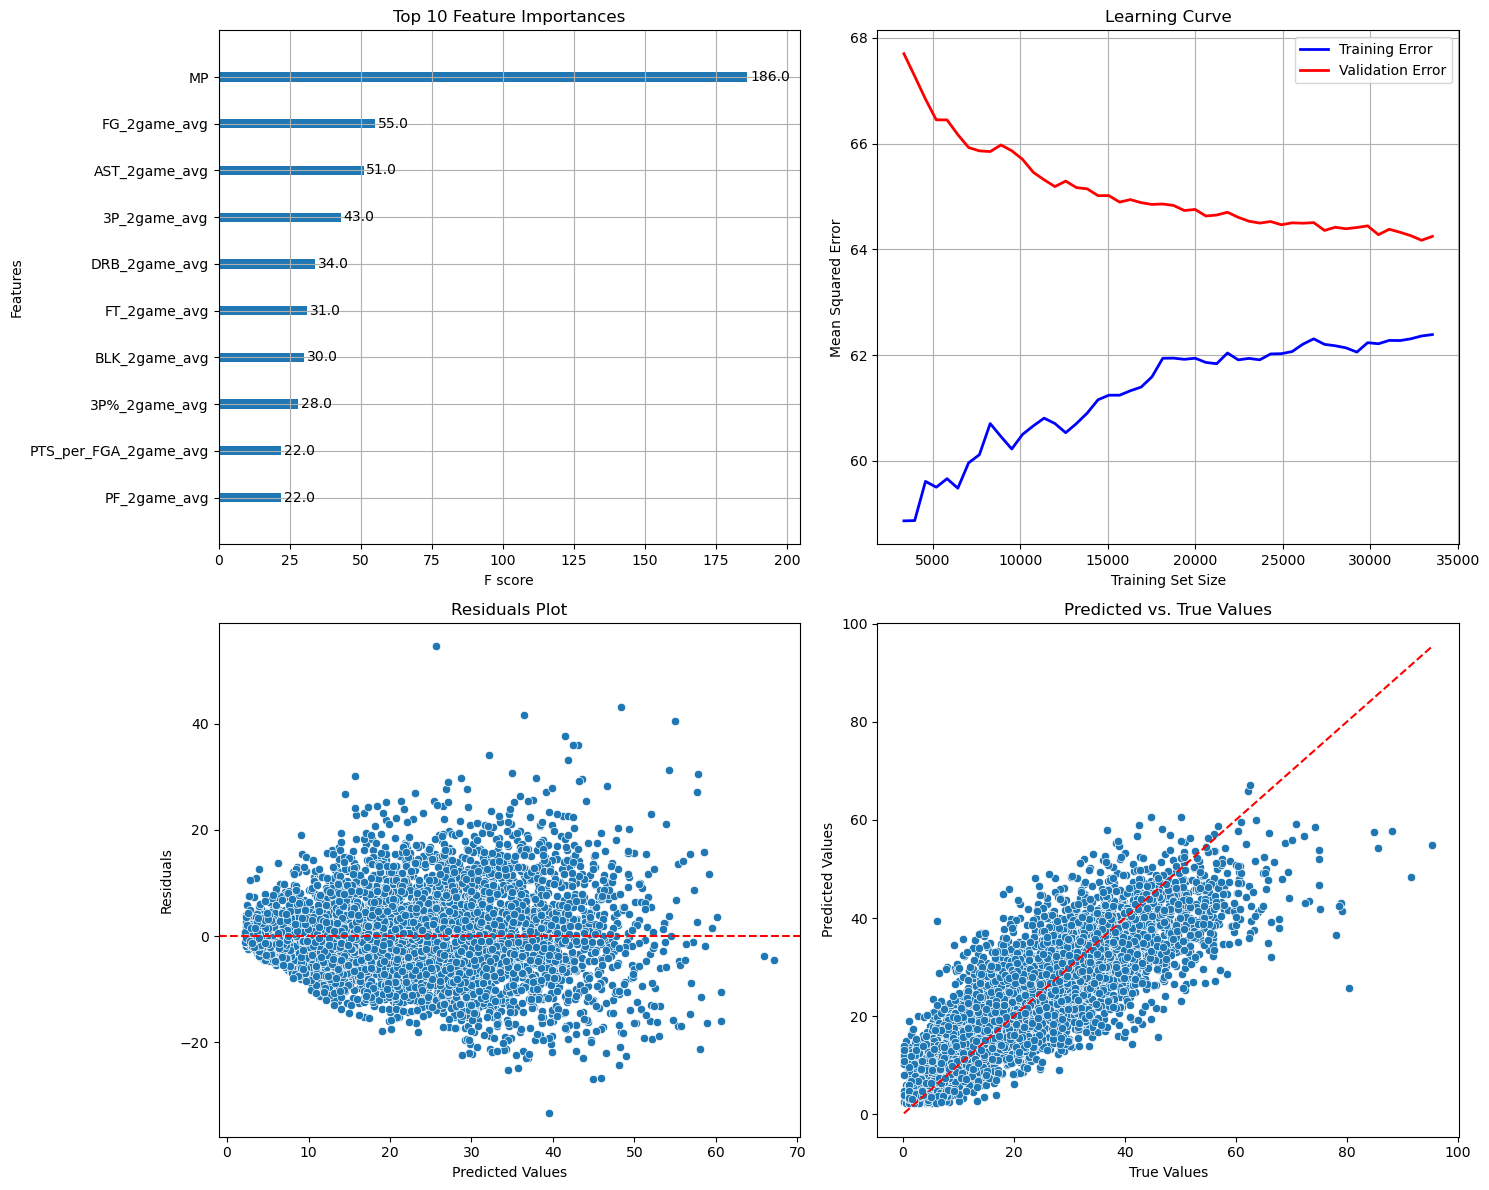

In [72]:
from xgboost import plot_importance

xgb_model = best_model
booster = xgb_model.get_booster()

fig, axs = plt.subplots(2, 2, figsize=(15, 12))

feature_names = X.columns.to_list()
booster.feature_names = feature_names


# 1. Feature Importance Plot
plot_importance(booster, max_num_features=10, ax=axs[0, 0], importance_type='weight')
axs[0, 0].set_title('Top 10 Feature Importances')

# 2. Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 50), n_jobs=-1
)
train_mean = -np.mean(train_scores, axis=1)
val_mean = -np.mean(val_scores, axis=1)
axs[0, 1].plot(train_sizes, train_mean, label='Training Error', color='blue', linewidth=2)
axs[0, 1].plot(train_sizes, val_mean, label='Validation Error', color='red', linewidth=2)
axs[0, 1].set_title('Learning Curve')
axs[0, 1].set_xlabel('Training Set Size')
axs[0, 1].set_ylabel('Mean Squared Error')
axs[0, 1].legend()
axs[0, 1].grid(True)


# 3. Residual Plot
residuals = y_val - y_val_pred
sns.scatterplot(x=y_val_pred, y=residuals, ax=axs[1, 0])
axs[1, 0].axhline(0, color='r', linestyle='--')
axs[1, 0].set_title('Residuals Plot')
axs[1, 0].set_xlabel('Predicted Values')
axs[1, 0].set_ylabel('Residuals')

# 4. Prediction vs. True Values Plot
sns.scatterplot(x=y_val, y=y_val_pred, ax=axs[1, 1])
axs[1, 1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
axs[1, 1].set_title('Predicted vs. True Values')
axs[1, 1].set_xlabel('True Values')
axs[1, 1].set_ylabel('Predicted Values')

# Adjust layout
plt.tight_layout()
plt.show()


## Testing

In [74]:
y_test_pred = best_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = root_mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(
f"Test MAE: {test_mae}\n" 
f"Test MSE: {test_mse}\n"
f"Test RMSE: {test_rmse}\n"
f"Test R2: {test_r2}"
    )


Test MAE: 6.163228800313608
Test MSE: 66.63370955961138
Test RMSE: 8.162947357395574
Test R2: 0.7177536081562295


## Save  XGBoost best_model

In [76]:
import joblib

joblib.dump(best_model, 'SwishPredict/models/best_xgboost_model.joblib')


['SwishPredict/models/best_xgboost_model.joblib']

## Training by Cluster

In [442]:
results = {}

for cluster_label, splits in tqdm(data_splits.items(), desc="Clusters", unit='cluster'):
    print(f"Running OptunaSearchCV for Cluster {cluster_label}")

    X_train = splits['X_train']
    X_val = splits['X_val']
    X_test = splits['X_test']
    y_train = splits['y_train']
    y_val = splits['y_val']
    y_test = splits['y_test']

    grid_search = OptunaSearchCV(
        estimator=xgb,
        param_distributions=xgb_params,
        cv=10,
        scoring='neg_mean_absolute_error',
        n_jobs=-1,
        verbose=1,
    )

    scaler = RobustScaler()

    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    grid_search.fit(X_train_scaled, y_train)

    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    y_val_pred = best_model.predict(X_val_scaled)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_r2 = r2_score(y_val, y_val_pred)

    print(f"Cluster {cluster_label} - Best Parameters: {best_params}")
    print(f"Cluster {cluster_label} - Validation MAE: {val_mae},\n" 
          f"Validation MSE: {val_mse},\n" 
          f"Validation R2: {val_r2}")
    
    results[cluster_label] = {
        'best_model': best_model,
        'best_params': best_params,
        'val_mae': val_mae,
        'val_mse': val_mse,
        'val_r2': val_r2,
    }

print("GridSearchCV complete for all clusters.")
for clust_label, result in results.items():
    print(f"\nCluster {clust_label}:")
    print(f"  Best Parameters: {result['best_params']}")
    print(f"  Validation MAE: {result['val_mae']}")
    print(f"  Validation MSE: {result['val_mse']}")
    print(f"  Validation R2: {result['val_r2']}")

Clusters:   0%|          | 0/3 [00:00<?, ?cluster/s][I 2024-09-01 21:20:25,398] A new study created in memory with name: no-name-e5d6ab68-1c20-4f2f-bf9b-e1739dc8c992


Running OptunaSearchCV for Cluster 0


[I 2024-09-01 21:20:29,840] Trial 1 finished with value: -4.724035428160372 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'learning_rate': 0.14820456556079578, 'subsample': 0.8785147523462616, 'colsample_bytree': 0.814078880316376, 'colsample_bylevel': 0.8567681331370277, 'colsample_bynode': 0.8196679515087679, 'gamma': 3.3062889965915767, 'lambda': 5.104928676331449, 'alpha': 2.371562852580728, 'max_delta_step': 9, 'booster': 'gbtree', 'seed': 42, 'tree_method': 'auto', 'objective': 'reg:tweedie', 'eval_metric': 'rmsle', 'base_score': 0.7489508197573098}. Best is trial 1 with value: -4.724035428160372.
[I 2024-09-01 21:20:31,187] Trial 2 finished with value: -4.719738529575368 and parameters: {'max_depth': 3, 'min_child_weight': 7, 'learning_rate': 0.14513139049046367, 'subsample': 0.8855107399478565, 'colsample_bytree': 0.8527943973787073, 'colsample_bylevel': 0.8628523669593782, 'colsample_bynode': 0.8364680681661032, 'gamma': 2.652847332909114, 'lambda': 4.947154040287774

Cluster 0 - Best Parameters: {'max_depth': 3, 'min_child_weight': 8, 'learning_rate': 0.14753461514117885, 'subsample': 0.8842726042917688, 'colsample_bytree': 0.7904642611118033, 'colsample_bylevel': 0.8325812769955951, 'colsample_bynode': 0.8412871722665679, 'gamma': 2.5514574162273194, 'lambda': 6.432614335061473, 'alpha': 3.8982632392096312, 'max_delta_step': 9, 'booster': 'gbtree', 'seed': 42, 'tree_method': 'auto', 'objective': 'reg:tweedie', 'eval_metric': 'rmsle', 'base_score': 0.5624787036754508}
Cluster 0 - Validation MAE: 4.7171182822681965,
Validation MSE: 41.043534318901905,
Validation R2: 0.6006038406881673
Running OptunaSearchCV for Cluster 1


[I 2024-09-01 21:20:45,851] Trial 2 finished with value: -7.3612436858693915 and parameters: {'max_depth': 3, 'min_child_weight': 7, 'learning_rate': 0.14031596480925176, 'subsample': 0.8733165482331829, 'colsample_bytree': 0.8298547127007325, 'colsample_bylevel': 0.8362124989274933, 'colsample_bynode': 0.8697385614334465, 'gamma': 3.887634617493024, 'lambda': 5.901457303553913, 'alpha': 2.597351360379159, 'max_delta_step': 7, 'booster': 'gbtree', 'seed': 42, 'tree_method': 'hist', 'objective': 'reg:tweedie', 'eval_metric': 'rmsle', 'base_score': 0.6351894509678485}. Best is trial 2 with value: -7.3612436858693915.
[I 2024-09-01 21:20:46,090] Trial 1 finished with value: -7.357464055247074 and parameters: {'max_depth': 3, 'min_child_weight': 7, 'learning_rate': 0.14457103158837695, 'subsample': 0.8754153756423939, 'colsample_bytree': 0.7523297456578341, 'colsample_bylevel': 0.8391508603915925, 'colsample_bynode': 0.8375221103291481, 'gamma': 3.0991473900696342, 'lambda': 6.865851511671

Cluster 1 - Best Parameters: {'max_depth': 3, 'min_child_weight': 7, 'learning_rate': 0.1470123993805266, 'subsample': 0.8855991030127853, 'colsample_bytree': 0.7534165785519071, 'colsample_bylevel': 0.8415178098642293, 'colsample_bynode': 0.8568880259997393, 'gamma': 2.683982422176189, 'lambda': 4.723655057510337, 'alpha': 2.744688689158574, 'max_delta_step': 7, 'booster': 'gbtree', 'seed': 42, 'tree_method': 'auto', 'objective': 'reg:tweedie', 'eval_metric': 'mae', 'base_score': 0.6484792147643015}
Cluster 1 - Validation MAE: 7.53721875764011,
Validation MSE: 91.03176015360143,
Validation R2: 0.5357157973798528
Running OptunaSearchCV for Cluster 2


[I 2024-09-01 21:20:59,091] Trial 1 finished with value: -7.00474442450674 and parameters: {'max_depth': 3, 'min_child_weight': 7, 'learning_rate': 0.14515065489396756, 'subsample': 0.8644318936088705, 'colsample_bytree': 0.8413980252870151, 'colsample_bylevel': 0.869524209800385, 'colsample_bynode': 0.8329082764975955, 'gamma': 2.2761713075439265, 'lambda': 6.172894789083337, 'alpha': 3.0791187194844936, 'max_delta_step': 6, 'booster': 'gbtree', 'seed': 42, 'tree_method': 'hist', 'objective': 'reg:tweedie', 'eval_metric': 'mae', 'base_score': 0.5676537750814641}. Best is trial 1 with value: -7.00474442450674.
[I 2024-09-01 21:20:59,389] Trial 2 finished with value: -7.016861787791361 and parameters: {'max_depth': 3, 'min_child_weight': 6, 'learning_rate': 0.14652293245022566, 'subsample': 0.8779132037172572, 'colsample_bytree': 0.8428257898292513, 'colsample_bylevel': 0.826285709952479, 'colsample_bynode': 0.8747260115727782, 'gamma': 3.942157622864504, 'lambda': 6.872454082956839, 'a

KeyboardInterrupt: 

# CatBoost

## Setup

In [45]:
cat = CatBoostRegressor(early_stopping_rounds=10)

cat_params = {
    'depth': IntDistribution(5, 7),  
    'learning_rate': FloatDistribution(0.04, 0.07), 
    'l2_leaf_reg': FloatDistribution(3.0, 9.5), 
    'iterations': IntDistribution(200, 500), 
    'subsample': FloatDistribution(0.85, 0.92), 
    'random_strength': FloatDistribution(1.0, 2.0),  
    'bagging_temperature': FloatDistribution(0.8, 1.0), 
    'boosting_type': CategoricalDistribution(['Ordered', 'Plain']),
    'loss_function': CategoricalDistribution(['MAE', 'RMSE', 'Quantile', 'LogLinQuantile']),
    'min_data_in_leaf': IntDistribution(1, 10), 
    'random_seed': IntDistribution(42, 42), 
}


## Training

In [46]:
grid_search = OptunaSearchCV(
    estimator=cat,
    param_distributions=cat_params,
    cv=10,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=3,
    random_state=42
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

grid_search.fit(X_train, y_train)

print(f"The best hyperparameters are {grid_search.best_params_}")

[I 2024-09-02 00:33:45,552] A new study created in memory with name: no-name-9e61711a-2aac-4235-b2a4-d72107a0483e


0:	learn: 14.3836001	total: 158ms	remaining: 33.8s
1:	learn: 13.9819578	total: 254ms	remaining: 27s
0:	learn: 11.3490831	total: 91.1ms	remaining: 20.6s
2:	learn: 13.5985841	total: 261ms	remaining: 18.5s
0:	learn: 14.2307454	total: 109ms	remaining: 22.8s
1:	learn: 10.8914976	total: 111ms	remaining: 12.5s
3:	learn: 13.2409209	total: 280ms	remaining: 14.8s
4:	learn: 12.9065824	total: 285ms	remaining: 12s
5:	learn: 12.5880165	total: 304ms	remaining: 10.6s
2:	learn: 10.5083083	total: 137ms	remaining: 10.2s
1:	learn: 13.6948349	total: 141ms	remaining: 14.7s
6:	learn: 12.3062436	total: 309ms	remaining: 9.19s
7:	learn: 12.0274040	total: 319ms	remaining: 8.24s
3:	learn: 10.1188245	total: 157ms	remaining: 8.73s
8:	learn: 11.7746077	total: 327ms	remaining: 7.48s
0:	learn: 5.6694065	total: 57.9ms	remaining: 11.9s
9:	learn: 11.5392579	total: 339ms	remaining: 6.95s
2:	learn: 13.2085078	total: 175ms	remaining: 12.1s
4:	learn: 9.7535665	total: 176ms	remaining: 7.82s
10:	learn: 11.3074686	total: 347ms	

[I 2024-09-02 00:34:08,639] Trial 0 finished with value: -6.058172332156444 and parameters: {'depth': 5, 'learning_rate': 0.046773146384490503, 'l2_leaf_reg': 5.465909784466332, 'iterations': 215, 'subsample': 0.8879554774013696, 'random_strength': 1.2415380181197455, 'bagging_temperature': 0.8498866887837802, 'boosting_type': 'Plain', 'loss_function': 'RMSE', 'min_data_in_leaf': 2, 'random_seed': 42}. Best is trial 0 with value: -6.058172332156444.


209:	learn: 7.9052977	total: 1.52s	remaining: 36.2ms
210:	learn: 7.9045005	total: 1.52s	remaining: 28.9ms
54:	learn: 8.0847513	total: 982ms	remaining: 2.77s
211:	learn: 7.9039045	total: 1.53s	remaining: 21.7ms
212:	learn: 7.9032184	total: 1.53s	remaining: 14.4ms
55:	learn: 8.0779310	total: 995ms	remaining: 2.73s
213:	learn: 7.9026494	total: 1.54s	remaining: 7.2ms
56:	learn: 8.0716912	total: 1s	remaining: 2.69s
214:	learn: 7.9023441	total: 1.54s	remaining: 0us
28:	learn: 3.2298195	total: 1.34s	remaining: 8.24s
57:	learn: 8.0658231	total: 1.02s	remaining: 2.67s
12:	learn: 7.7994688	total: 277ms	remaining: 4.56s
72:	learn: 8.0096236	total: 1.32s	remaining: 2.47s
73:	learn: 8.0068361	total: 1.34s	remaining: 2.46s
35:	learn: 3.1397040	total: 1.68s	remaining: 7.98s
13:	learn: 7.6535673	total: 310ms	remaining: 4.72s
74:	learn: 8.0037274	total: 1.35s	remaining: 2.43s
0:	learn: 14.3773039	total: 18ms	remaining: 6.63s
75:	learn: 8.0004694	total: 1.38s	remaining: 2.43s
1:	learn: 13.9646531	total:

[I 2024-09-02 00:34:28,346] Trial 3 finished with value: -6.046919102294663 and parameters: {'depth': 5, 'learning_rate': 0.06358936827801095, 'l2_leaf_reg': 5.573603026795456, 'iterations': 210, 'subsample': 0.8636696535691072, 'random_strength': 1.1791300003090863, 'bagging_temperature': 0.9625421110113255, 'boosting_type': 'Ordered', 'loss_function': 'RMSE', 'min_data_in_leaf': 7, 'random_seed': 42}. Best is trial 3 with value: -6.046919102294663.


104:	learn: 5.9968254	total: 3.22s	remaining: 3.74s
190:	learn: 7.9212640	total: 1.5s	remaining: 1.41s
191:	learn: 7.9202673	total: 1.51s	remaining: 1.4s
105:	learn: 5.9957712	total: 3.24s	remaining: 3.69s
192:	learn: 7.9194320	total: 1.52s	remaining: 1.4s
205:	learn: 7.8900573	total: 3.58s	remaining: 69.5ms
201:	learn: 2.9472658	total: 9.41s	remaining: 233ms
193:	learn: 7.9188207	total: 1.53s	remaining: 1.39s
206:	learn: 7.8892101	total: 3.6s	remaining: 52.1ms
194:	learn: 7.9183701	total: 1.54s	remaining: 1.39s
106:	learn: 5.9944111	total: 3.26s	remaining: 3.66s
195:	learn: 7.9173162	total: 1.57s	remaining: 1.39s
107:	learn: 5.9936821	total: 3.28s	remaining: 3.62s
207:	learn: 7.8882626	total: 3.62s	remaining: 34.8ms
196:	learn: 7.9165263	total: 1.57s	remaining: 1.38s
202:	learn: 2.9464495	total: 9.46s	remaining: 186ms
197:	learn: 7.9158237	total: 1.58s	remaining: 1.37s
108:	learn: 5.9931746	total: 3.3s	remaining: 3.57s
208:	learn: 7.8872412	total: 3.64s	remaining: 17.4ms
198:	learn: 7

[I 2024-09-02 00:34:41,428] Trial 4 finished with value: -6.04736585040104 and parameters: {'depth': 5, 'learning_rate': 0.048298382345916234, 'l2_leaf_reg': 8.48346426091411, 'iterations': 370, 'subsample': 0.8696109637144972, 'random_strength': 1.5752715859900657, 'bagging_temperature': 0.9558773167768623, 'boosting_type': 'Plain', 'loss_function': 'RMSE', 'min_data_in_leaf': 1, 'random_seed': 42}. Best is trial 3 with value: -6.046919102294663.


360:	learn: 7.8422908	total: 2.54s	remaining: 63.3ms
361:	learn: 7.8418733	total: 2.54s	remaining: 56.2ms
282:	learn: 7.8177210	total: 3.08s	remaining: 1.13s
362:	learn: 7.8408524	total: 2.55s	remaining: 49.1ms
363:	learn: 7.8404162	total: 2.55s	remaining: 42.1ms
364:	learn: 7.8396081	total: 2.56s	remaining: 35ms
283:	learn: 7.8177056	total: 3.1s	remaining: 1.12s
44:	learn: 6.1870479	total: 1.52s	remaining: 6.13s
365:	learn: 7.8387733	total: 2.56s	remaining: 28ms
366:	learn: 7.8379278	total: 2.56s	remaining: 21ms
284:	learn: 7.8174943	total: 3.11s	remaining: 1.11s
367:	learn: 7.8372004	total: 2.57s	remaining: 14ms
368:	learn: 7.8367174	total: 2.57s	remaining: 6.98ms
48:	learn: 3.0515351	total: 2.31s	remaining: 7.45s
285:	learn: 7.8174615	total: 3.12s	remaining: 1.1s
369:	learn: 7.8365947	total: 2.58s	remaining: 0us
286:	learn: 7.8172572	total: 3.13s	remaining: 1.09s
45:	learn: 6.1785602	total: 1.55s	remaining: 6.1s
46:	learn: 6.1721037	total: 1.57s	remaining: 6s
287:	learn: 7.8162211	t

[I 2024-09-02 00:35:02,853] Trial 1 finished with value: -6.035974675823915 and parameters: {'depth': 6, 'learning_rate': 0.06504847352782685, 'l2_leaf_reg': 7.250808467507856, 'iterations': 227, 'subsample': 0.8922057843589856, 'random_strength': 1.8856427407410181, 'bagging_temperature': 0.8409997008173598, 'boosting_type': 'Ordered', 'loss_function': 'MAE', 'min_data_in_leaf': 5, 'random_seed': 42}. Best is trial 1 with value: -6.035974675823915.


65:	learn: 8.0992666	total: 566ms	remaining: 2.75s
66:	learn: 8.0926488	total: 574ms	remaining: 2.74s
83:	learn: 3.0056204	total: 3.92s	remaining: 5.74s
67:	learn: 8.0873011	total: 580ms	remaining: 2.72s
68:	learn: 8.0824365	total: 588ms	remaining: 2.71s
60:	learn: 8.1210427	total: 2.65s	remaining: 15.4s
225:	learn: 5.9148318	total: 7.04s	remaining: 31.1ms
69:	learn: 8.0770977	total: 597ms	remaining: 2.7s
70:	learn: 8.0712833	total: 604ms	remaining: 2.69s
71:	learn: 8.0669317	total: 614ms	remaining: 2.69s
226:	learn: 5.9142310	total: 7.06s	remaining: 0us
72:	learn: 8.0617068	total: 620ms	remaining: 2.67s
84:	learn: 3.0045556	total: 3.97s	remaining: 5.7s
74:	learn: 8.0512931	total: 654ms	remaining: 2.72s
85:	learn: 3.0037572	total: 4.01s	remaining: 5.64s
77:	learn: 8.0384717	total: 689ms	remaining: 2.73s
63:	learn: 8.1005108	total: 2.77s	remaining: 15.2s
86:	learn: 3.0027650	total: 4.04s	remaining: 5.58s
78:	learn: 8.0340696	total: 699ms	remaining: 2.73s
87:	learn: 3.0025942	total: 4.07

[I 2024-09-02 00:35:15,559] Trial 5 finished with value: -6.037252851076938 and parameters: {'depth': 7, 'learning_rate': 0.047337437117565315, 'l2_leaf_reg': 9.009151215342222, 'iterations': 387, 'subsample': 0.9035970665996423, 'random_strength': 1.9510551699362106, 'bagging_temperature': 0.8795827372993832, 'boosting_type': 'Plain', 'loss_function': 'RMSE', 'min_data_in_leaf': 8, 'random_seed': 42}. Best is trial 1 with value: -6.035974675823915.


135:	learn: 2.9720054	total: 6.9s	remaining: 3.6s
258:	learn: 5.8993818	total: 12.5s	remaining: 6.09s
371:	learn: 7.8519691	total: 15.3s	remaining: 1.77s
136:	learn: 2.9718189	total: 6.95s	remaining: 3.55s
259:	learn: 5.8991343	total: 12.6s	remaining: 6.04s
372:	learn: 7.8513668	total: 15.3s	remaining: 1.73s
137:	learn: 2.9715515	total: 6.99s	remaining: 3.5s
260:	learn: 5.8986687	total: 12.6s	remaining: 5.99s
0:	learn: 11.3386091	total: 47.2ms	remaining: 12s
373:	learn: 7.8512837	total: 15.4s	remaining: 1.69s
138:	learn: 2.9711920	total: 7.02s	remaining: 3.44s
1:	learn: 10.8724824	total: 89.9ms	remaining: 11.4s
261:	learn: 5.8980518	total: 12.7s	remaining: 5.94s
139:	learn: 2.9708555	total: 7.05s	remaining: 3.38s
374:	learn: 7.8512438	total: 15.4s	remaining: 1.65s
2:	learn: 10.4830321	total: 134ms	remaining: 11.3s
140:	learn: 2.9704322	total: 7.09s	remaining: 3.32s
375:	learn: 7.8511954	total: 15.5s	remaining: 1.6s
262:	learn: 5.8978289	total: 12.7s	remaining: 5.9s
3:	learn: 10.0878232

[I 2024-09-02 00:35:30,172] Trial 2 finished with value: -6.028694034392988 and parameters: {'depth': 7, 'learning_rate': 0.06533886594554542, 'l2_leaf_reg': 9.374698374949595, 'iterations': 207, 'subsample': 0.9020373738968089, 'random_strength': 1.3982455293833875, 'bagging_temperature': 0.8273044175227565, 'boosting_type': 'Ordered', 'loss_function': 'Quantile', 'min_data_in_leaf': 10, 'random_seed': 42}. Best is trial 2 with value: -6.028694034392988.


154:	learn: 5.9606437	total: 7.3s	remaining: 10.8s
273:	learn: 7.8834661	total: 11.6s	remaining: 5.95s
203:	learn: 2.9415516	total: 10.1s	remaining: 149ms
153:	learn: 5.9725274	total: 5.05s	remaining: 3.31s
155:	learn: 5.9600802	total: 7.33s	remaining: 10.8s
274:	learn: 7.8821999	total: 11.6s	remaining: 5.91s
154:	learn: 5.9720893	total: 5.09s	remaining: 3.28s
204:	learn: 2.9412714	total: 10.2s	remaining: 99.4ms
156:	learn: 5.9596807	total: 7.37s	remaining: 10.7s
205:	learn: 2.9408057	total: 10.2s	remaining: 49.6ms
155:	learn: 5.9713397	total: 5.13s	remaining: 3.25s
275:	learn: 7.8821640	total: 11.7s	remaining: 5.88s
157:	learn: 5.9585460	total: 7.42s	remaining: 10.7s
276:	learn: 7.8821607	total: 11.7s	remaining: 5.82s
206:	learn: 2.9405898	total: 10.3s	remaining: 0us
156:	learn: 5.9708147	total: 5.18s	remaining: 3.23s
277:	learn: 7.8813893	total: 11.7s	remaining: 5.78s
158:	learn: 5.9579311	total: 7.47s	remaining: 10.6s
157:	learn: 5.9704119	total: 5.22s	remaining: 3.21s
159:	learn: 5

[I 2024-09-02 00:36:45,198] Trial 8 finished with value: -6.033563489805884 and parameters: {'depth': 6, 'learning_rate': 0.06641521555782204, 'l2_leaf_reg': 8.62246114980843, 'iterations': 255, 'subsample': 0.9086079430633155, 'random_strength': 1.7978798351651801, 'bagging_temperature': 0.9680448475620261, 'boosting_type': 'Ordered', 'loss_function': 'MAE', 'min_data_in_leaf': 8, 'random_seed': 42}. Best is trial 2 with value: -6.028694034392988.


232:	learn: 5.9750816	total: 5.15s	remaining: 3.21s
216:	learn: 5.9073051	total: 8.88s	remaining: 6.87s
233:	learn: 5.9747330	total: 5.17s	remaining: 3.18s
234:	learn: 5.9737547	total: 5.19s	remaining: 3.16s
217:	learn: 5.9069181	total: 8.91s	remaining: 6.83s
235:	learn: 5.9729890	total: 5.2s	remaining: 3.13s
0:	learn: 14.2790316	total: 35.5ms	remaining: 14.7s
218:	learn: 5.9057808	total: 8.94s	remaining: 6.78s
236:	learn: 5.9722110	total: 5.22s	remaining: 3.11s
219:	learn: 5.9050606	total: 8.97s	remaining: 6.73s
1:	learn: 13.8561742	total: 64.9ms	remaining: 13.4s
237:	learn: 5.9717506	total: 5.25s	remaining: 3.09s
238:	learn: 5.9714238	total: 5.28s	remaining: 3.07s
2:	learn: 13.4620700	total: 95.4ms	remaining: 13.1s
220:	learn: 5.9047277	total: 9s	remaining: 6.68s
3:	learn: 13.0877371	total: 122ms	remaining: 12.5s
239:	learn: 5.9710265	total: 5.31s	remaining: 3.05s
221:	learn: 5.9040514	total: 9.03s	remaining: 6.63s
222:	learn: 5.9038738	total: 9.05s	remaining: 6.58s
4:	learn: 12.7285

[I 2024-09-02 00:37:07,916] Trial 9 finished with value: -6.031503468863274 and parameters: {'depth': 5, 'learning_rate': 0.05704784537701234, 'l2_leaf_reg': 3.298697910514822, 'iterations': 378, 'subsample': 0.8710667033484109, 'random_strength': 1.938514421624205, 'bagging_temperature': 0.8719662534686708, 'boosting_type': 'Ordered', 'loss_function': 'MAE', 'min_data_in_leaf': 5, 'random_seed': 42}. Best is trial 2 with value: -6.028694034392988.


375:	learn: 5.8933329	total: 7.67s	remaining: 40.8ms
164:	learn: 7.9319796	total: 5.52s	remaining: 8.36s
365:	learn: 5.8295613	total: 13s	remaining: 677ms
376:	learn: 5.8930645	total: 7.69s	remaining: 20.4ms
165:	learn: 7.9313505	total: 5.55s	remaining: 8.32s
366:	learn: 5.8286896	total: 13.1s	remaining: 641ms
377:	learn: 5.8925650	total: 7.73s	remaining: 0us
166:	learn: 7.9311143	total: 5.58s	remaining: 8.28s
367:	learn: 5.8283848	total: 13.1s	remaining: 605ms
167:	learn: 7.9300047	total: 5.6s	remaining: 8.23s
368:	learn: 5.8279068	total: 13.1s	remaining: 570ms
168:	learn: 7.9289778	total: 5.63s	remaining: 8.19s
369:	learn: 5.8273946	total: 13.2s	remaining: 534ms
169:	learn: 7.9279483	total: 5.65s	remaining: 8.15s
370:	learn: 5.8271852	total: 13.2s	remaining: 498ms
170:	learn: 7.9276384	total: 5.67s	remaining: 8.09s
371:	learn: 5.8267138	total: 13.2s	remaining: 462ms
171:	learn: 7.9271854	total: 5.7s	remaining: 8.05s
172:	learn: 7.9255625	total: 5.72s	remaining: 8s
372:	learn: 5.82604

[I 2024-09-02 00:37:25,205] Trial 6 finished with value: -6.026024755467263 and parameters: {'depth': 7, 'learning_rate': 0.049432832171896965, 'l2_leaf_reg': 8.584743083410103, 'iterations': 415, 'subsample': 0.9199214734806628, 'random_strength': 1.669121394922819, 'bagging_temperature': 0.9907899348233179, 'boosting_type': 'Ordered', 'loss_function': 'RMSE', 'min_data_in_leaf': 8, 'random_seed': 42}. Best is trial 6 with value: -6.026024755467263.


138:	learn: 5.9658275	total: 4.17s	remaining: 7.38s
408:	learn: 7.8103698	total: 10s	remaining: 147ms
139:	learn: 5.9651000	total: 4.2s	remaining: 7.35s
409:	learn: 7.8095434	total: 10s	remaining: 122ms
140:	learn: 5.9640920	total: 4.22s	remaining: 7.31s
410:	learn: 7.8090969	total: 10s	remaining: 97.8ms
411:	learn: 7.8074702	total: 10.1s	remaining: 73.3ms
141:	learn: 5.9634118	total: 4.25s	remaining: 7.27s
412:	learn: 7.8073674	total: 10.1s	remaining: 48.9ms
142:	learn: 5.9625692	total: 4.28s	remaining: 7.24s
413:	learn: 7.8072705	total: 10.1s	remaining: 24.4ms
143:	learn: 5.9622027	total: 4.3s	remaining: 7.2s
414:	learn: 7.8071791	total: 10.1s	remaining: 0us
144:	learn: 5.9617275	total: 4.32s	remaining: 7.15s
0:	learn: 11.3797406	total: 15.6ms	remaining: 6s
1:	learn: 11.0079376	total: 31.4ms	remaining: 6.01s
2:	learn: 10.6512920	total: 47.1ms	remaining: 6s
3:	learn: 10.3361974	total: 61.8ms	remaining: 5.88s
4:	learn: 10.0160122	total: 76.8ms	remaining: 5.83s
5:	learn: 9.7325065	total

[I 2024-09-02 00:37:35,213] Trial 7 finished with value: -6.0206850549530655 and parameters: {'depth': 7, 'learning_rate': 0.051804620309043356, 'l2_leaf_reg': 4.889065328907314, 'iterations': 385, 'subsample': 0.8588010988269562, 'random_strength': 1.8906318722644802, 'bagging_temperature': 0.992947748406559, 'boosting_type': 'Ordered', 'loss_function': 'MAE', 'min_data_in_leaf': 1, 'random_seed': 42}. Best is trial 7 with value: -6.0206850549530655.


382:	learn: 5.8159422	total: 5.84s	remaining: 30.5ms
383:	learn: 5.8155160	total: 5.85s	remaining: 15.2ms
384:	learn: 5.8152175	total: 5.87s	remaining: 0us
0:	learn: 11.4039171	total: 16.9ms	remaining: 6.5s
1:	learn: 11.0161738	total: 33.5ms	remaining: 6.42s
2:	learn: 10.6775136	total: 49.7ms	remaining: 6.33s
3:	learn: 10.3502704	total: 65.4ms	remaining: 6.22s
4:	learn: 10.0399750	total: 80.5ms	remaining: 6.12s
5:	learn: 9.7482789	total: 96.4ms	remaining: 6.09s
6:	learn: 9.4821276	total: 112ms	remaining: 6.03s
7:	learn: 9.2329047	total: 127ms	remaining: 6s
8:	learn: 9.0032137	total: 143ms	remaining: 5.98s
9:	learn: 8.7871885	total: 158ms	remaining: 5.92s
10:	learn: 8.5948817	total: 173ms	remaining: 5.88s
11:	learn: 8.4167026	total: 188ms	remaining: 5.84s
12:	learn: 8.2483094	total: 203ms	remaining: 5.81s
13:	learn: 8.0889549	total: 218ms	remaining: 5.78s
14:	learn: 7.9406762	total: 234ms	remaining: 5.76s
15:	learn: 7.8140444	total: 249ms	remaining: 5.74s
16:	learn: 7.6989370	total: 264

## Validation

In [47]:
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

y_val_pred = best_model.predict(X_val)
val_mae = mean_absolute_error(y_val, y_val_pred)
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = root_mean_squared_error(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(
f"Best Parameters: {best_params}\n"
f"Validation MAE: {val_mae}\n" 
f"Validation MSE: {val_mse}\n"
f"Validation RMSE: {val_rmse}\n"
f"Validation R2: {val_r2}"
    )

results_whole = {
'best_model': best_model,
'best_params': best_params,
'val_mae': val_mae,
'val_mse': val_mse,
'val_r2': val_r2,
}


Best Parameters: {'depth': 7, 'learning_rate': 0.051804620309043356, 'l2_leaf_reg': 4.889065328907314, 'iterations': 385, 'subsample': 0.8588010988269562, 'random_strength': 1.8906318722644802, 'bagging_temperature': 0.992947748406559, 'boosting_type': 'Ordered', 'loss_function': 'MAE', 'min_data_in_leaf': 1, 'random_seed': 42}
Validation MAE: 6.015093859621132
Validation MSE: 65.19152328266742
Validation RMSE: 8.074126781433854
Validation R2: 0.7032469712836766


# Catboost Visualization

0:	learn: 11.3839521	total: 54.7ms	remaining: 19.9s
0:	learn: 11.3143105	total: 72.9ms	remaining: 26.5s
0:	learn: 11.3035439	total: 58.6ms	remaining: 21.3s
1:	learn: 10.9721355	total: 83.6ms	remaining: 15.1s
1:	learn: 10.8612132	total: 97.5ms	remaining: 17.6s
1:	learn: 10.8742677	total: 81.5ms	remaining: 14.7s
2:	learn: 10.4546855	total: 111ms	remaining: 13.3s
2:	learn: 10.5587087	total: 108ms	remaining: 13s
2:	learn: 10.4835295	total: 107ms	remaining: 12.8s
3:	learn: 10.0850925	total: 128ms	remaining: 11.5s
4:	learn: 9.7304611	total: 137ms	remaining: 9.85s
3:	learn: 10.2310347	total: 132ms	remaining: 11.9s
5:	learn: 9.4083993	total: 148ms	remaining: 8.8s
6:	learn: 9.1275187	total: 158ms	remaining: 8.08s
3:	learn: 10.1465188	total: 148ms	remaining: 13.3s
7:	learn: 8.8751471	total: 167ms	remaining: 7.42s
0:	learn: 11.3566899	total: 79ms	remaining: 28.7s
4:	learn: 9.9234142	total: 174ms	remaining: 12.5s
8:	learn: 8.6469526	total: 181ms	remaining: 7.14s
9:	learn: 8.4142530	total: 189ms	re

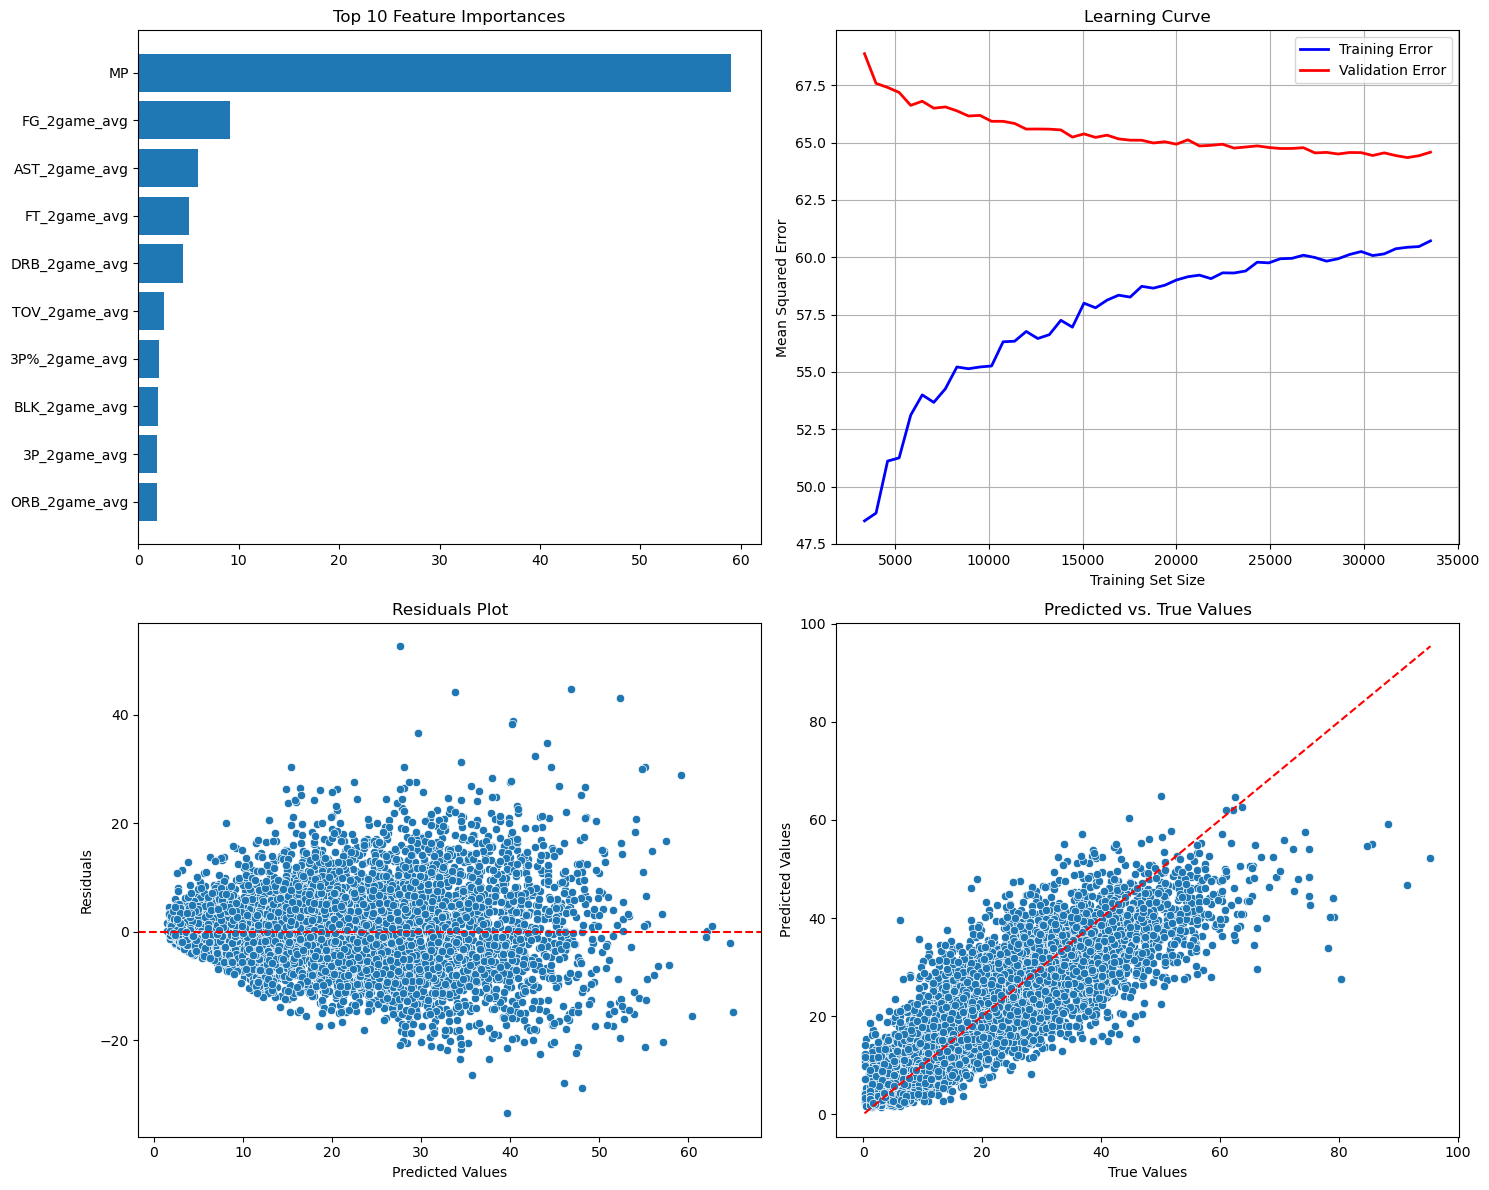

In [23]:
from catboost import Pool

cat_model = best_model

fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# 1. Feature Importance Plot (using CatBoost's method)
feature_importances = cat_model.get_feature_importance(Pool(X_train, label=y_train))
feature_names = X.columns.to_list()
sorted_idx = np.argsort(feature_importances)[-10:]
axs[0, 0].barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
axs[0, 0].set_yticks(range(len(sorted_idx)))
axs[0, 0].set_yticklabels(np.array(feature_names)[sorted_idx])
axs[0, 0].set_title('Top 10 Feature Importances')

# 2. Learning Curve (using CatBoost model)
train_sizes, train_scores, val_scores = learning_curve(
    cat_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 50), n_jobs=-1
)
train_mean = -np.mean(train_scores, axis=1)
val_mean = -np.mean(val_scores, axis=1)
axs[0, 1].plot(train_sizes, train_mean, label='Training Error', color='blue', linewidth=2)
axs[0, 1].plot(train_sizes, val_mean, label='Validation Error', color='red', linewidth=2)
axs[0, 1].set_title('Learning Curve')
axs[0, 1].set_xlabel('Training Set Size')
axs[0, 1].set_ylabel('Mean Squared Error')
axs[0, 1].legend()
axs[0, 1].grid(True)

# 3. Residual Plot
residuals = y_val - y_val_pred
sns.scatterplot(x=y_val_pred, y=residuals, ax=axs[1, 0])
axs[1, 0].axhline(0, color='r', linestyle='--')
axs[1, 0].set_title('Residuals Plot')
axs[1, 0].set_xlabel('Predicted Values')
axs[1, 0].set_ylabel('Residuals')

# 4. Prediction vs. True Values Plot
sns.scatterplot(x=y_val, y=y_val_pred, ax=axs[1, 1])
axs[1, 1].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
axs[1, 1].set_title('Predicted vs. True Values')
axs[1, 1].set_xlabel('True Values')
axs[1, 1].set_ylabel('Predicted Values')

# Adjust layout
plt.tight_layout()
plt.show()

# Catboost Testing

In [49]:
y_test_pred = best_model.predict(X_test)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = root_mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(
f"Test MAE: {test_mae}\n" 
f"Test MSE: {test_mse}\n"
f"Test RMSE: {test_rmse}\n"
f"Test R2: {test_r2}"
    )


Test MAE: 6.126478025130144
Test MSE: 66.58706651617008
Test RMSE: 8.160089859564666
Test R2: 0.7179511782870676


# Model Training 1 (Not Used)

In [ ]:

metrics = {cluster: {} for cluster in data_splits.keys()}
def gridSearchCV(data_splits, models):
    for cluster_label, splits in data_splits.items():
        X_train, X_val, X_test = splits['X_train'], splits['X_val'], splits['X_test']
        y_train, y_val, y_test = splits['y_train'], splits['y_val'], splits['y_test']

        scaler = RobustScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)

        metrics[cluster_label] = {} 

        for model_name, (model, params) in models.items():
            print(f"Training {model_name} on Cluster {cluster_label}")

            pipeline = Pipeline([
                ('scaler', RobustScaler()),
                ('regressor', model)
            ])

            grid_search = GridSearchCV(pipeline, param_grid={'regressor__' + key: value for key, value in params.items()}, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)

            grid_search.fit(X_train_scaled, y_train)

            # Best model and hyperparameters
            best_model = grid_search.best_estimator_
            print(f"  Best parameters for {model_name}: {grid_search.best_params_}")

            # Predict on validation set
            y_val_pred = best_model.predict(X_val_scaled)
            y_test_pred = best_model.predict(X_test_scaled)

            # Calculate metrics
            val_mae = mean_absolute_error(y_val, y_val_pred)
            val_r2 = r2_score(y_val, y_val_pred)
            val_mse = mean_squared_error(y_val, y_val_pred)
            test_mse = mean_squared_error(y_val, y_val_pred)
            test_mae = mean_absolute_error(y_test, y_test_pred)
            test_r2 = r2_score(y_test, y_test_pred)

            print(f"  Validation MAE for {model_name}: {val_mae}")
            print(f"  Validation R2 for {model_name}: {val_r2}")
            print(f"  Test MAE for {model_name}: {test_mae}")
            print(f"  Test R2 for {model_name}: {test_r2}")

            # Store metrics
            metrics[cluster_label][model_name] = {
                'val_mae': val_mae,
                'val_mse': val_mse,
                'val_r2': val_r2,
                'test_mae': test_mae,
                'test_mse': test_mse,
                'test_r2': test_r2,
                'best_params': grid_search.best_params_
            }
    return metrics

## Evaluate

In [ ]:
for metric in ['val_mae', 'val_r2', 'test_mae', 'test_r2']:
    plt.figure(figsize=(10, 6))
    for model in models.keys():
        values = [metrics[cluster_label][model][metric] for cluster_label in metrics.keys()]
        sns.lineplot(x=list(metrics.keys()), y=values, label=f'{model}', marker='o')

    plt.title(f'{metric.upper()} Comparison Across Clusters for Each Model')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel(metric.upper())
    plt.xlabel('Clusters')
    plt.legend(title='Model')
    plt.show()

KeyError: 'LinearRegression'

<Figure size 1000x600 with 0 Axes>

In [ ]:
data = []

# Iterate through the metrics dictionary and collect the data
for cluster_label, models_metrics in metrics.items():
    for model_name, scores in models_metrics.items():
        data.append({
            'Cluster': cluster_label,
            'Model': model_name,
            'Validation MAE': scores['val_mae'],
            'Validation R2': scores['val_r2'],
            'Test MAE': scores['test_mae'],
            'Test R2': scores['test_r2']
        })

# Create a DataFrame from the data
df_metrics = pd.DataFrame(data)

# Sort the DataFrame by 'Model' and 'Cluster'
df_metrics = df_metrics.sort_values(by=['Model', 'Cluster'])

# Group by 'Model' and display mini tables for each model
grouped = df_metrics.groupby('Model')

# Set the display format for floats
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Display mini tables in a compact, two-column format
import IPython.display as display
for model_name, group in grouped:
    print(f"Model: {model_name}")
    
    # Create a compact display
    compact_table = pd.concat([group[['Cluster', 'Validation MAE', 'Validation R2']].reset_index(drop=True),
                               group[['Test MAE', 'Test R2']].reset_index(drop=True)], axis=1)
    compact_table.columns = ['Cluster', 'Validation MAE', 'Validation R2', 'Test MAE', 'Test R2']
    
    display.display(compact_table)
    print("\n" + "-"*50 + "\n")


Model: CatBoost


Cluster  Validation MAE  Validation R2  Test MAE  Test R2
0        0          4.5604         0.5713    4.6072   0.6221
1        1          7.0821         0.5270    7.1146   0.5490
2        2          7.8449         0.5160    7.8871   0.5624
3        3          4.2812         0.6547    4.2308   0.6144


--------------------------------------------------

Model: KNeighborsRegressor


Cluster  Validation MAE  Validation R2  Test MAE  Test R2
0        0          5.5108         0.4272    5.6393   0.4582
1        1          7.8535         0.4413    8.0638   0.4236
2        2          8.6980         0.4234    8.6122   0.4687
3        3          5.3163         0.4996    5.2125   0.4470


--------------------------------------------------

Model: LightGBM


Cluster  Validation MAE  Validation R2  Test MAE  Test R2
0        0          4.6779         0.5529    4.6518   0.6167
1        1          7.1238         0.5292    7.2256   0.5368
2        2          7.8871         0.5041    7.9226   0.5606
3        3          4.2926         0.6482    4.2536   0.6091


--------------------------------------------------

Model: LinearRegression


Cluster  Validation MAE  Validation R2  Test MAE  Test R2
0        0          4.5434         0.5710    4.6589   0.6159
1        1          7.1147         0.5163    7.1216   0.5477
2        2          7.9809         0.5021    7.8823   0.5657
3        3          4.3167         0.6462    4.2178   0.6140


--------------------------------------------------

Model: LinearSVR


Cluster  Validation MAE  Validation R2  Test MAE  Test R2
0        0          4.5279         0.5697    4.6302   0.6160
1        1          7.1030         0.5158    7.0963   0.5471
2        2          7.9561         0.5013    7.8792   0.5655
3        3          4.3091         0.6437    4.1791   0.6174


--------------------------------------------------

Model: SGDRegressor


Cluster  Validation MAE  Validation R2  Test MAE  Test R2
0        0          4.5321         0.5712    4.6657   0.6145
1        1          7.1238         0.5152    7.1269   0.5480
2        2          7.9826         0.5022    7.8865   0.5645
3        3          4.3281         0.6443    4.2268   0.6144


--------------------------------------------------

Model: XGBoost


Cluster  Validation MAE  Validation R2  Test MAE  Test R2
0        0          4.6596         0.5534    4.6475   0.6200
1        1          7.1893         0.5117    7.1896   0.5394
2        2          7.8602         0.5064    7.9766   0.5553
3        3          4.3089         0.6489    4.2960   0.5978


--------------------------------------------------



Dropping KNN Regression because R2 score over all clusters is below .5

Models to further evaluate:
- CatBoost
- LightGBM
- Linear Regression
- LinearSVR
- SGDRegressor
- XGBoost